In [8]:
import numpy as np
from matplotlib import pyplot as plt 
import matplotlib as mpl
from matplotlib import rc
from ipywidgets import interact, widgets
from IPython.display import display
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
plt.style.use('default')
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'],'size':20})
rc('text', usetex=False)
rc('axes', titlesize=18, labelsize=20)
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

# Example Hilbert transform

Let us define a simple function with modulated frequency in form of a sweep. 
In general we can think of non-stationary frequency oscillations composed of
$$x(t) = \sum_i A_i(t) e^{i\phi_i(t)}$$
for which the Amplitudes can do what they want and the angles $\phi_i$ are the integrated version of the instantaneous frequency $\omega$:
$$\phi(t) = \int_0^t \omega(t') \mathrm{d}t' \mathrm{mod} 2\pi $$
The first signal is the sum of oscillatory signals with phase shift $\Delta\phi$ and amplitudes $A_1$ and $A_2$
Signal: $A_1 sin(\omega_1 t) + A_2 sin(\omega_2 t + \Delta\phi)$

The second signal is the same, but with $\Delta\phi=0$ and $\omega_1(t) = \omega_1 * t$ hence a linear ramp in frequency which gives, that the instantaneous phase $\phi(t)= \int_0^t \omega_1(t') \mathrm{d}t' = \frac{\omega_1}{2}t^2$

In [10]:
from scipy.signal import hilbert,spectrogram

def signal(t,w1,w2,a1,a2,dPhi=0):
    return a1*np.sin(w1*t)+a2*np.sin(w2*t+dPhi)

def signal_variousfreq(t,w1,w2,a1,a2):
    return a1*np.sin((w1/2*t**2))+a2*np.sin(w2*t)


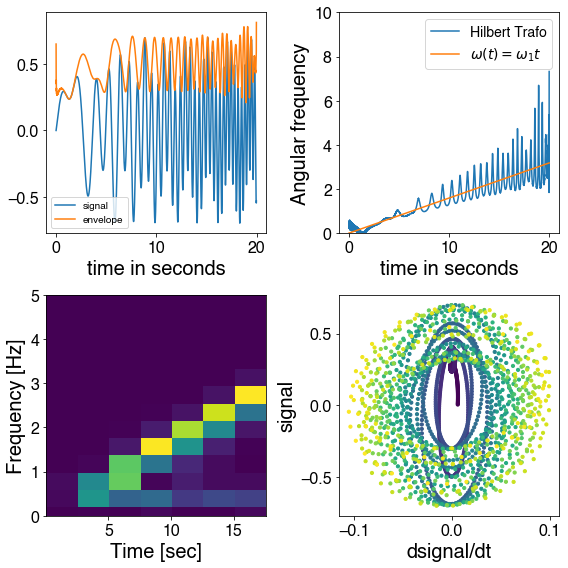

In [29]:
duration = 20.0
fs = 100.0
samples = int(fs*duration)
ts = np.arange(samples) / fs

w1 = 1 #Hz
w2 = 3 #Hz
a1 = .5
a2 = .2 

sig = signal_variousfreq(ts,w1,w2,a1,a2)

# calculate Hilbert
analytic_signal = hilbert(sig)  # analytic signal (complex numbers)
# amplitude enveloope of Hilbert
amplitude_envelope = np.abs(analytic_signal) #real numbers
instantaneous_phase = np.unwrap(np.angle(analytic_signal)) #unwraps the angle (hence angle is up to 2pi after first full turn and up to 4pi after second and so on)
instantaneous_frequency = (np.diff(instantaneous_phase) / (2.0*np.pi) * fs) #frequency = Dphase/Dt

fig, [(ax0, ax1),(ax2,ax3)] = plt.subplots(2,2,figsize=(8,8))
ax0.plot(ts, sig, label='signal')
ax0.plot(ts, amplitude_envelope, label='envelope')
ax0.set_xlabel("time in seconds")
ax0.legend()

ax1.plot(ts[1:], instantaneous_frequency, label='Hilbert Trafo')
ax1.plot(ts[1:], w1*ts[1:]/(2*np.pi), label=r'$\omega(t) = \omega_1 t$')
ax1.set_xlabel("time in seconds")
ax1.set_ylabel("Angular frequency")
ax1.set_ylim(0, 10.0)
ax1.legend(fontsize=14)

f,t,Sxx = spectrogram(sig,fs,noverlap=5)
sc = ax2.pcolormesh(t, f, Sxx)
ax2.set_ylabel('Frequency [Hz]')
ax2.set_xlabel('Time [sec]')
#plt.colorbar(sc)
ax2.set_ylim([0,5])

# lissajous figure (signal versus first derivative)
ax3.scatter(np.diff(sig),sig[1:],c=ts[1:],s=10)
ax3.set_ylabel('signal')
ax3.set_xlabel('dsignal/dt')



fig.tight_layout()



In [30]:
def plot_interact(freq1=3,freq2=1,amp1=0.2,amp2=0.3,duration=20,fs=100):
    samples = int(fs*duration)
    ts = np.arange(samples) / fs
    sig = signal_variousfreq(ts,freq1,freq2,amp1,amp2)

    fig, ax = plt.subplots(figsize=(6,5))


    f,t,Sxx = spectrogram(sig,fs,window='boxcar',scaling='spectrum')
    sc = ax.pcolormesh(t, f, Sxx)
    ax.set_yticklabels([])
    ax.set_xlabel('Time [sec]')
    #ax.set_ylim([0])
    #plt.colorbar(sc)
    ax_divider = make_axes_locatable(ax)
    cax1 = ax_divider.append_axes("right", size="7%", pad="2%")
    cb1 = fig.colorbar(sc, cax=cax1)

    ax1 = ax_divider.append_axes("left", size="15%", pad="5%")
    fourier = np.fft.fft(sig)
    freq = np.fft.fftfreq(ts.shape[-1])
    signalPSD = np.absolute(fourier)**2
    i = freq>0
    ax1.plot(10*np.log10(signalPSD[i]),freq[i])
    ax1.set_ylim(ax.get_ylim())

    ax2 = ax_divider.append_axes("top", size="15%", pad="7%")
    ax2.plot(ts,sig)
    ax1.set_ylabel('Frequency [Hz]')

    fig.tight_layout()
    plt.show()

# freq1_range = np.linspace(0.01, 10.0, 100)
# freq2_range = np.linspace(0.01, 10.0, 100)
# amp1_range = np.linspace(0, 2.0, 100)
# amp2_range = np.linspace(0, 2.0, 100)
# duration_range = np.linspace(.0, 2.0, 100)


# Create interactive sliders
freq1_slider = widgets.FloatSlider(value=3.0, min=0.01, max=10.0, step=0.1, description='freq1:')
freq2_slider = widgets.FloatSlider(value=1, min=0.01, max=2.0, step=0.01, description='freq2:')
amp1_slider = widgets.FloatSlider(value=0.1, min=0, max=2, step=0.01, description='amp1:')
amp2_slider = widgets.FloatSlider(value=0.2, min=0, max=2.0, step=0.01, description='amp2:')
duration_slider = widgets.FloatSlider(value=20.0, min=1.0, max=200.0, step=1, description='T:')
fs_slider   = widgets.FloatSlider(value=100.0, min=1.0, max=1000.0, step=1, description='f_s:')

# Create interactive plot
interactive_plot = interact(plot_interact, freq1=freq1_slider,freq2=freq2_slider,amp1=amp1_slider,amp2=amp2_slider,duration=duration_slider,fs=fs_slider)



interactive(children=(FloatSlider(value=3.0, description='freq1:', max=10.0, min=0.01), FloatSlider(value=1.0,…

In [ ]:
f,t,Sxx = wigner(sig,fs,noverlap=5)
sc = ax2.pcolormesh(t, f, Sxx)
ax2.set_ylabel('Frequency [Hz]')
ax2.set_xlabel('Time [sec]')
#plt.colorbar(sc)
ax2.set_ylim([0,5])
fig.tight_layout()

# Wigner distribution

In [128]:
import tftb

In [146]:
duration = 20.0
fs = 100.0
samples = int(fs*duration)
ts = np.arange(samples) / fs
sig = signal_variousfreq(ts,1,3,0.5,0.4)

In [147]:
wvd = tftb.processing.WignerVilleDistribution(sig, timestamps=ts)
tfr_wvd, t_wvd, f_wvd = wvd.run()
np.fft.fftshift(tfr_wvd, axes=0)

array([[ 0.00000000e+00,  1.44557340e-04, -2.89796412e-04, ...,
         2.73952053e-01, -3.31600199e-01,  3.44303629e-01],
       [ 0.00000000e+00,  1.44557340e-04, -2.89792119e-04, ...,
         2.73943620e-01, -3.31596810e-01,  3.44303629e-01],
       [ 0.00000000e+00,  1.44557340e-04, -2.89779240e-04, ...,
         2.73918322e-01, -3.31586644e-01,  3.44303629e-01],
       ...,
       [ 0.00000000e+00,  1.44557340e-04, -2.89757776e-04, ...,
         2.73876160e-01, -3.31569701e-01,  3.44303629e-01],
       [ 0.00000000e+00,  1.44557340e-04, -2.89779240e-04, ...,
         2.73918322e-01, -3.31586644e-01,  3.44303629e-01],
       [ 0.00000000e+00,  1.44557340e-04, -2.89792119e-04, ...,
         2.73943620e-01, -3.31596810e-01,  3.44303629e-01]])

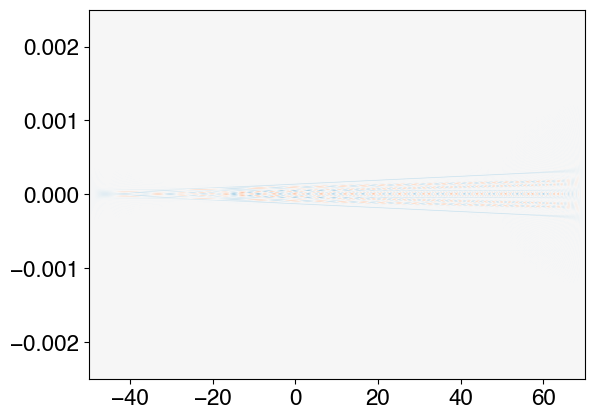

In [148]:
f_wvd = np.fft.fftshift(np.fft.fftfreq(tfr_wvd.shape[0], d=2 * fs))
df_wvd = f_wvd[1]-f_wvd[0]  # the frequency step in the WVT
im = plt.imshow(np.fft.fftshift(tfr_wvd, axes=0), aspect='auto', origin='lower',
       extent=(ts[0] - fs/2, ts[-1] + fs/2,
               f_wvd[0]-df_wvd/2, f_wvd[-1]+df_wvd/2),cmap='RdBu')

<ipython-input-134-c9f666d5eb41>:4: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  sc = ax.pcolormesh(t_wvd, np.fft.fftshift(f_wvd), np.fft.fftshift(tfr_wvd, axes=0))


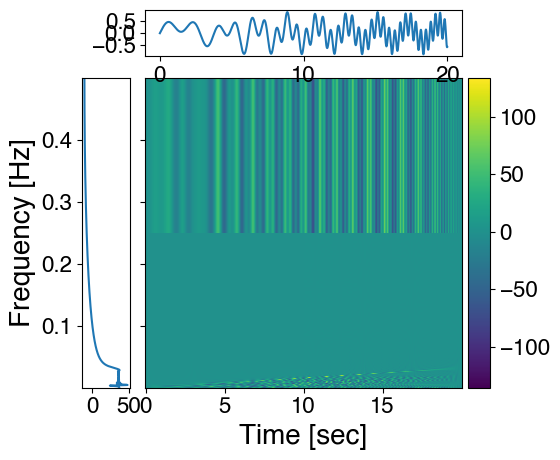

In [134]:
fig, ax = plt.subplots(figsize=(6,5))


sc = ax.pcolormesh(t_wvd, np.fft.fftshift(f_wvd), np.fft.fftshift(tfr_wvd, axes=0))
ax.set_yticklabels([])
ax.set_xlabel('Time [sec]')
#ax.set_ylim([0])
#plt.colorbar(sc)
ax_divider = make_axes_locatable(ax)
cax1 = ax_divider.append_axes("right", size="7%", pad="2%")
cb1 = fig.colorbar(sc, cax=cax1)

ax1 = ax_divider.append_axes("left", size="15%", pad="5%")
fourier = np.fft.fft(sig)
freq = np.fft.fftfreq(ts.shape[-1])
signalPSD = np.absolute(fourier)**2
i = freq>0
ax1.plot(10*np.log10(signalPSD[i]),freq[i])
ax1.set_ylim(ax.get_ylim())

ax2 = ax_divider.append_axes("top", size="15%", pad="7%")
ax2.plot(ts,sig)
ax1.set_ylabel('Frequency [Hz]')

fig.tight_layout()
plt.show()

# Wavelet trafo:
$e^{i\omega t-\sigma t^2}$

# Averaging phases

### Use $|m| = |\frac{1}{N} \sum_{k=1}^N e^{i\phi_k}|$
as a phase is basically a vector, this gives the length of the average vector

# Inter trial phase clusterign ITPC
from Morlet wavelet analysis one gains a representation of $\phi(f,t)$ and $A(f,t)$
while the amplitudes are interesting by themselves, the angles can give rise of phase clustering if multiple time series $k=1,...,N$ exist
to calculate it one can use the above formula to calculate the phase consistency. If m is small, then the phases are all over the place, or antisynchronous if m is large the phases are synchronized

# 1/f scalefree noise:
$P(f) \propto 1/f^\alpha$, $0<\alpha<2$.
Pink noise is used for clocks (Press, W. H. (1978). "Flicker noises in astronomy and elsewhere". Comments in Astrophysics. 7 (4))
Detrended fluctuation analysis: DFA & Hurste exponent

# Hilbert trafo
"reconstructs" imaginary part of signal -> phase and angle BUT: cannot operate on broadband signals, so one needs FIR filters to bandpass filter the data -> Filter Hilbert Method, similar to wavelet trafo

# Multi taper method
for analysis of non-phase locked, non-time locked data!
